In [1]:
%matplotlib inline

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

# We need to import all the skimage modules one by one
from skimage.io import imread
from skimage.io import imshow
from skimage.transform import resize

from scipy.ndimage import convolve

from collections import Counter

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 04. Working with Images and Text
### Reading, exploring and analyzing, feature extraction
Topics:
* Processing images: information extraction;
* Image histograms;
* Convolution kernels;
* Fourier transform. Image spectrum;
* Image morphology;
* Processing text: information extraction;
* “Bag of words” model, n-grams;
* TF-IDF.

In [3]:
# Quick check
print("It is working!")

It is working!


Feature extraction - In machine learning, pattern recognition, and image processing, feature extraction starts from an initial set of measured data and builds derived values (features) intended to be informative and non-redundant, facilitating the subsequent learning and generalization steps, and in some cases leading to better human interpretations. Feature extraction is related to dimensionality reduction.


Feature extraction vs. Feature engineering - Feature engineering is the process of working with already **extracted or existing** features.

### Image processing
Understanding what people see

For working with images we use the `Skimage` library. `OpenCV` and `PIL` are also good choices, but skimage is more user-friendly.

The first function, which we are going to look at is `imread()`. It's used to read standard images. Now let's just try to read an image using the imread function. We have a tiger image in the `/images` directory. Let's try using it.

In [4]:
imread("images/tiger.jpg")

array([[[223, 224, 226],
        [223, 224, 226],
        [223, 224, 226],
        ...,
        [225, 225, 227],
        [225, 225, 227],
        [225, 225, 227]],

       [[223, 224, 226],
        [223, 224, 226],
        [223, 224, 226],
        ...,
        [225, 225, 227],
        [225, 225, 227],
        [225, 225, 227]],

       [[224, 225, 227],
        [224, 225, 227],
        [224, 225, 227],
        ...,
        [226, 226, 228],
        [226, 226, 228],
        [226, 226, 228]],

       ...,

       [[199, 161, 124],
        [197, 159, 120],
        [198, 156, 118],
        ...,
        [ 80,  39,  19],
        [ 79,  38,  18],
        [ 79,  38,  18]],

       [[186, 147, 106],
        [185, 143, 103],
        [183, 140,  98],
        ...,
        [ 83,  42,  22],
        [ 82,  41,  21],
        [ 82,  41,  21]],

       [[175, 133,  91],
        [172, 129,  87],
        [169, 124,  82],
        ...,
        [ 84,  43,  23],
        [ 84,  43,  23],
        [ 83,  42,  22]]

Hmm... look at what we got. An array of arrays of 8bit integers. Pretty interesting result if you ask me. But why we got the image in this kind of format?

In [5]:
# Let's save the image for later use...
tiger_image = imread("images/tiger.jpg")

Now, let's check the shape of the image.

In [6]:
tiger_image.shape

(600, 580, 3)

Oh, look! :O It is 3-dimesional? But why? Let's take a look at the first two dimensions. The first dimension shows the height, while the second one shows the width. So it turns out, that `skimage` represents them in `HxW` format. But what is the 3D dimension? *Depth?* No. Good guess, though. The third dimensions shows the number of channels. (Red, Green, Blue). There are images with only one channel. Like black-n'-white ones, but here we are working with colorfull image, so we are using both the R, G and B channels. RGB is not the only way to represent a color, though. We have HSL and HSV also. Likewise, we have Lab Color *(for coloring black and white images)*. L represents the black and white colors.

To better understand this, let's take the pixel on 20px Height, and 120px Width and look at it's RGB values.

In [7]:
tiger_image[20, 120]


#-------------------
#       R    G    B

array([235, 235, 233], dtype=uint8)

Likewise, we could have images with more than 3 dimensions. We could have a Infra-red protection filter for example. Look on `coperenicus satelite images cloud ir`.

Slicing is also supproted on skimage. This way we could get the different color channels.

In [8]:
tiger_red = tiger_image[:, :, 0]
tiger_green = tiger_image[:, :, 1]
tiger_blue = tiger_image[:, :, 2]

And now, if we check, we could see, that there is no color-channel dimension.

In [9]:
tiger_red.shape

(600, 580)

The most important thing is, that all the image channels show the same thing. Otherwise if we place all the channels on top of another, the image will be **invalid**.

To show the image we could use the `imshow()` method from matplotlib.

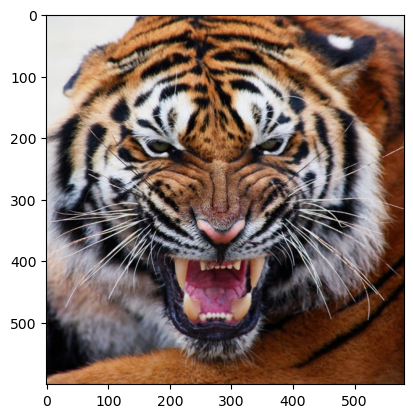

In [10]:
plt.imshow(tiger_image)
plt.show()

We could also show only the channels...

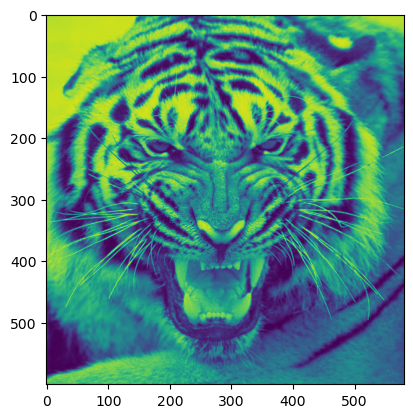

In [11]:
plt.imshow(tiger_red)
plt.show()

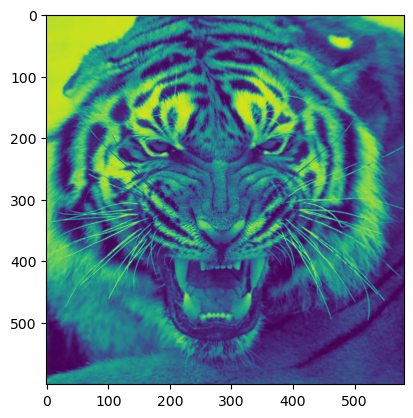

In [12]:
plt.imshow(tiger_green)
plt.show()

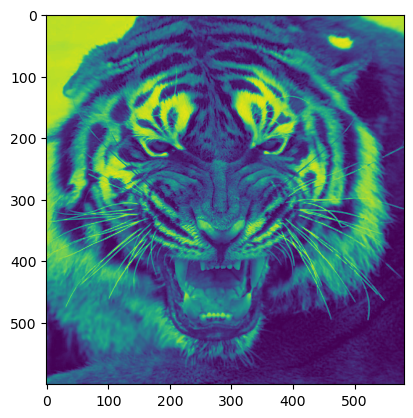

In [13]:
plt.imshow(tiger_blue)
plt.show()

**THE IMAGES ARE NOT THE SAME!!** Look at the darker ares. They show the rgb values.

Skimage also has a `imshow()` method, which is actually the matplotlib method xd ...

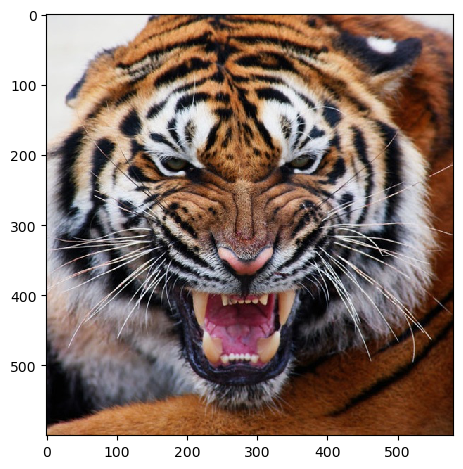

In [14]:
imshow(tiger_image)

# Uncomment if you do not believe me
# plt.show()

To scare the shit out of you, i will use a color map to show only the red channel on the tiger image :)

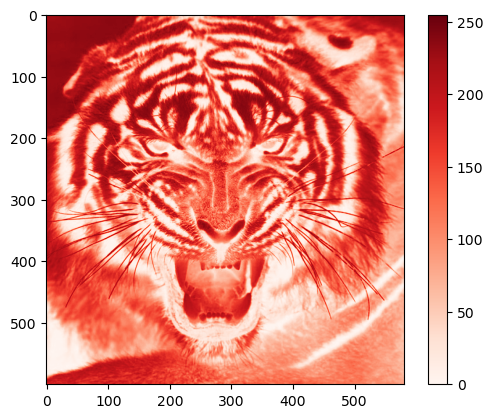

In [15]:
plt.imshow(tiger_red, cmap = "Reds")
# plt.imshow(tiger_red, cmap = "Reds_r") - Reversed, but looks lame
plt.colorbar()
plt.show()

We could also make a histogram

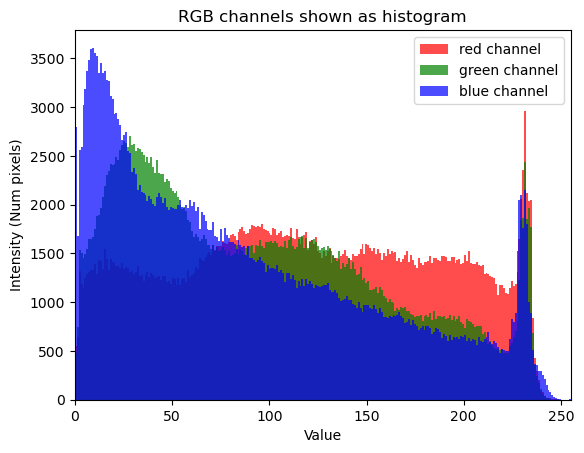

In [16]:
plt.hist(tiger_red.ravel(), bins=256, color = "r", label = "red channel", alpha = 0.7)
plt.hist(tiger_green.ravel(), bins=256, color = "g", label = "green channel", alpha = 0.7)
plt.hist(tiger_blue.ravel(), bins=256, color = "b", label = "blue channel", alpha = 0.7)

plt.xlim(0, 255)

plt.legend()
plt.title("RGB channels shown as histogram")

plt.ylabel("Intensity (Num pixels)")
plt.xlabel("Value")

plt.show()

The `ravel()` methods gets all arrays and places them one next to another. *Converts 2D matrix into 1D array.*

In [17]:
print("\w ravel: ", tiger_red.ravel().shape)
print("no ravel: ", tiger_red.shape)

\w ravel:  (348000,)
no ravel:  (600, 580)


In [18]:
# See :)
600 * 580

348000

In [19]:
# We could make it black and white using these coefficients 
# We see green with the most intensity. That's why the coefficient is so big.
tiger_grayscale = 0.299 * tiger_red + 0*587 * tiger_green + 0.114 * tiger_blue

These coefficients are the same as the ones our eyes understand as red green and blue.
Look at the green and red part. This is the reason some people are colorblind :d
<img src="images/color-perception-cones.png" />

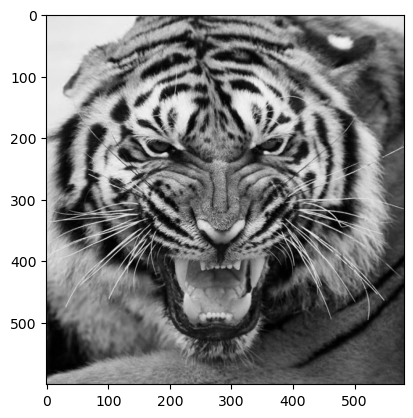

In [20]:
plt.imshow(tiger_grayscale, cmap = "gray")
plt.show()

Also, good to know - we could resize images getting every second pixel.

In [21]:
tiger_small = tiger_image[::2, ::2, :]

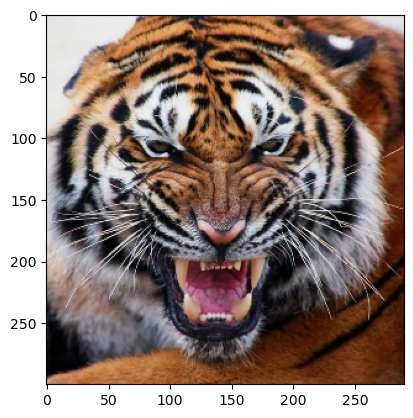

In [22]:
plt.imshow(tiger_small)
plt.show()

In [23]:
print("The normal tiger image \t", tiger_image.shape, np.product(tiger_image.shape), "product")
print("The small tiger image \t", tiger_small.shape, np.product(tiger_small.shape), "product")

The normal tiger image 	 (600, 580, 3) 1044000 product
The small tiger image 	 (300, 290, 3) 261000 product


### Convolution
* Convolution kernel(filter)
    * A small, usually 3x3, matrix of numbers
* Convolution process
    * Input: image, kernel;
    * Output: new image;
    * Combining the image and a kernel
        * Apply the kernel over each pixel
        * Multiply the values element-wise (**Hadamard product**)
        * Sum all values
        * Assign the sum to the corresponding pixel in the output image
            * Image corners are treated in different ways, not really important how

In [24]:
# Let's get a part of our image
tiger_sample = tiger_grayscale[100:110, 100:110].astype(int)

# Call it
tiger_sample

array([[72, 70, 70, 67, 60, 53, 51, 51, 55, 53],
       [72, 67, 63, 63, 57, 51, 45, 41, 44, 44],
       [71, 64, 59, 59, 54, 50, 45, 39, 39, 39],
       [69, 62, 56, 52, 54, 54, 50, 43, 40, 37],
       [64, 57, 51, 51, 55, 56, 56, 49, 41, 34],
       [62, 56, 51, 52, 55, 55, 52, 45, 37, 32],
       [62, 56, 52, 53, 54, 51, 45, 39, 37, 34],
       [57, 51, 47, 46, 48, 50, 46, 40, 35, 32],
       [53, 50, 48, 47, 47, 51, 49, 41, 33, 30],
       [49, 49, 49, 48, 47, 47, 44, 38, 32, 31]])

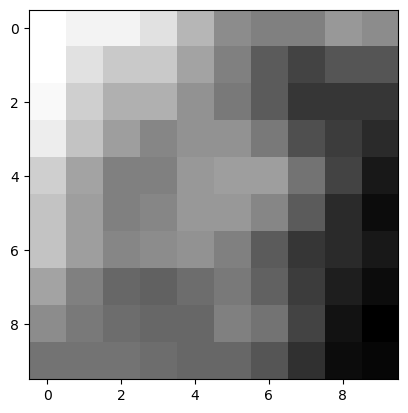

In [25]:
plt.imshow(tiger_sample, cmap = "gray")
plt.show()

In [26]:
# Then we create the filter
conv_filter = np.array([
    [0, 1, 0],
    [0, -1, 0],
    [0, 1, 0]
])

This is how the filter is applied:
<img src="images/expl.png" />

After the filter is done, we do the `sliding window`.
<img src="images/conv.gif">

We have an method for this, as well. It is called `convolve` and it is in the `scipy.ndimage` module.

In [27]:
# Here is an example use
conv_sample = convolve(tiger_sample, conv_filter)

# Call it
conv_sample

array([[72, 67, 63, 63, 57, 51, 45, 41, 44, 44],
       [71, 67, 66, 63, 57, 52, 51, 49, 50, 48],
       [70, 65, 60, 56, 57, 55, 50, 45, 45, 42],
       [66, 59, 54, 58, 55, 52, 51, 45, 40, 36],
       [67, 61, 56, 53, 54, 53, 46, 39, 36, 35],
       [64, 57, 52, 52, 54, 52, 49, 43, 41, 36],
       [57, 51, 46, 45, 49, 54, 53, 46, 35, 30],
       [58, 55, 53, 54, 53, 52, 48, 40, 35, 32],
       [53, 50, 48, 47, 48, 46, 41, 37, 34, 33],
       [53, 50, 48, 47, 47, 51, 49, 41, 33, 30]])

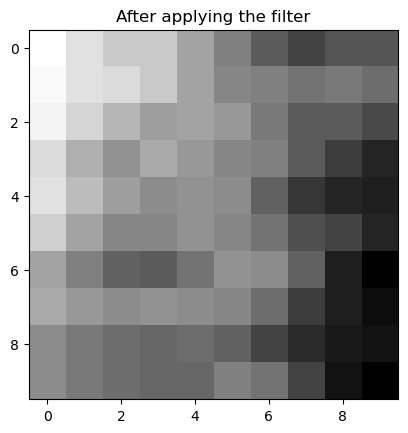

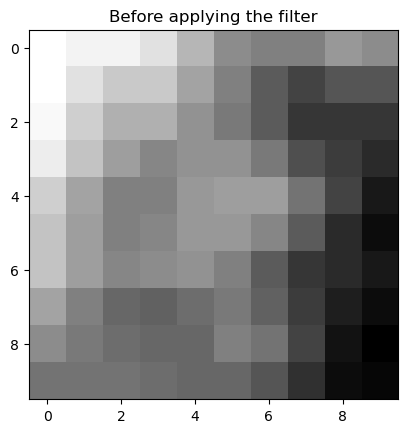

In [28]:
plt.imshow(conv_sample, cmap = "gray")
plt.title("After applying the filter")
plt.show()

plt.imshow(tiger_sample, cmap = "gray")
plt.title("Before applying the filter")
plt.show()

The result is not that exciding yet, but look what happens when we apply the filter to a bigger image.

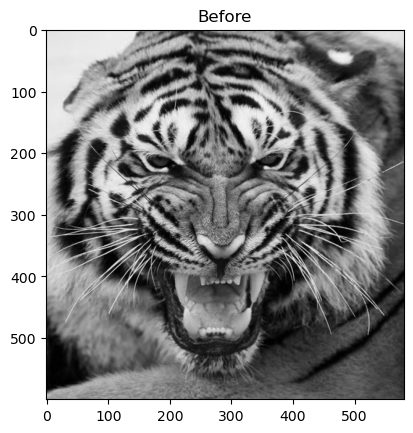

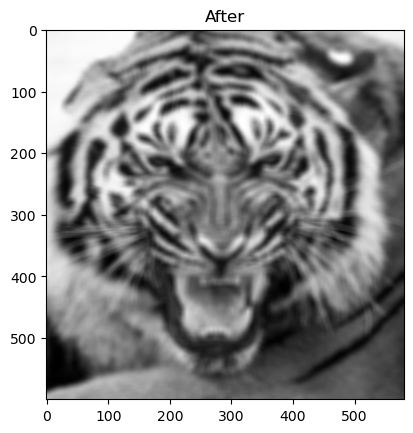

In [29]:
conv_filter = np.ones([11, 11]) / 121
plt.imshow(tiger_grayscale, cmap = "gray")
plt.title("Before")
plt.show()

result = convolve(tiger_grayscale, conv_filter)
plt.imshow(convolve(tiger_grayscale, conv_filter), cmap = "gray")
plt.title("After")
plt.show()

Ok, ok, cool exercise. Let's subtract the original image drom the blurred one. You can see, that we got only the details.

In [30]:
result - tiger_grayscale

array([[ 0.37545455,  0.37545455,  0.37545455, ...,  0.159     ,
         0.16630579,  0.16630579],
       [ 0.413     ,  0.413     ,  0.413     , ...,  0.14557851,
         0.15535537,  0.15535537],
       [ 0.06755372,  0.06755372,  0.06755372, ..., -0.28766942,
        -0.27542149, -0.27542149],
       ...,
       [-3.21718182, -2.23844628, -2.50692562, ...,  0.1251157 ,
         0.56872727,  0.58885124],
       [ 2.81009091,  3.33616529,  4.24842975, ..., -1.10247107,
        -0.63002479, -0.58753719],
       [ 7.84468595,  9.06357851, 10.25224793, ..., -1.50828926,
        -1.42836364, -0.96416529]])

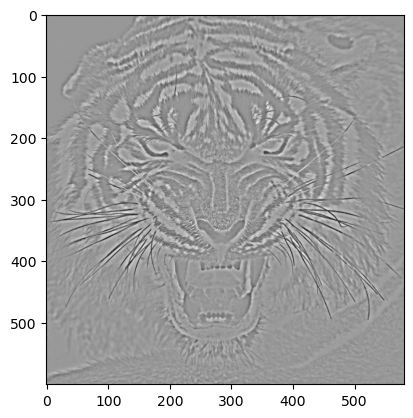

In [31]:
plt.imshow(result - tiger_grayscale, cmap = "gray")
plt.show()

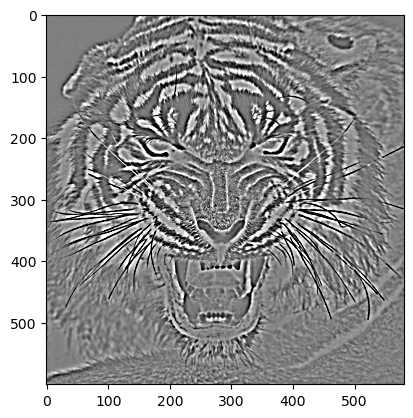

In [32]:
# We could make it more contrast if we give it some boundaries
plt.imshow(result - tiger_grayscale, cmap = "gray", vmin = -20, vmax = 20)
plt.show()

Now let's try doing [sobel filter](https://en.wikipedia.org/wiki/Sobel_operator). It's used for edge detection. You can read more from the wiki provided above.

In [33]:
# Basically, the filter
sobel_filter = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])

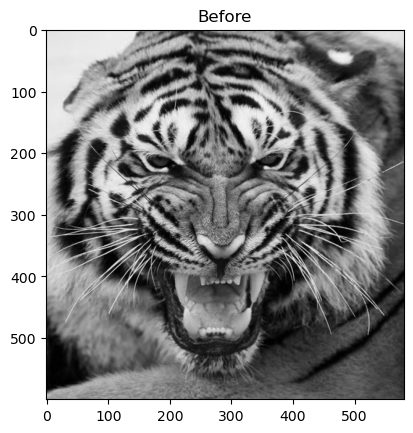

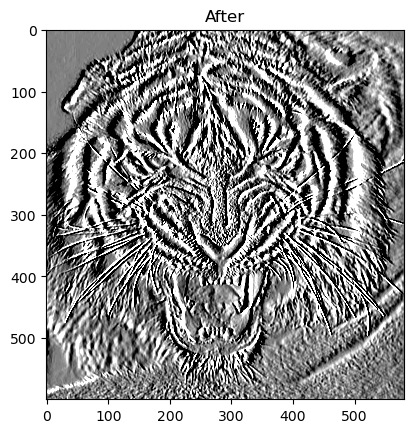

In [34]:
# Now let's use it
plt.imshow(tiger_grayscale, cmap = "gray")
plt.title("Before")
plt.show()

result = convolve(tiger_grayscale, sobel_filter)
plt.imshow(result, cmap = "gray", vmin = -20, vmax = 20)
plt.title("After")
plt.show()

In [35]:
print("Min: ", result.min())
print("Max: ", result.max())

Min:  -336.083
Max:  328.86199999999997


### Image morphology
* Four main operations
    * Dilation, erosion, opening, closing
* A simple series of algorithms for image transformation
* Basic methodology
    * Choose a structuring element (e.g., 2x2 square or cross)
    * Move the element around the image
    * Apply an operation
* Input: Binary image
    * Pixel values 0 and 1, not [0; 255]
        * This is called thresholding
* Output: Transformed image

First, we need to make the image black and white. This is how we do it in a nutshell.
<img src="images/bnw.png" />

In [36]:
thresholded = tiger_grayscale.copy()

In [37]:
thresholded[thresholded < 50] = 0
thresholded[thresholded >= 50] = 255

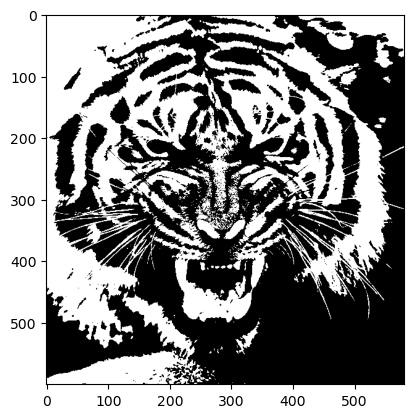

In [38]:
plt.imshow(thresholded, cmap = "gray")
plt.show()

It is called thresholding, because we are creating a "border".

*(First we need to get our structuring element)* <br />
Here are the different operations from the image morphology:
* **Erosion**: replace all values with the min value
    * Strips away a layer of pixels
    * Holes become larger
    * Small regions are eliminated
<img src="images/erosion.png">

* **Dilation**: replace all values with the max value
    * Adds a layer of pixels
    * Gaps become smaller
    * Small gaps are filled in
<img src="images/dilation.png">

* **Opening**: erosion followed by dilation
    * Pixels which survived erosion are restored to their original size
    * Opens up a gap between two objects connected by thin bridges
<img src="images/opening.png">
    
* **Closing**: dilation followed by erosion
    * Fills in holes in the regions while keeping the initial region sizes
<img src="images/closing.png">

And yes, they are done using the sliding window method. :)
You can find these methods in `skimage.morphology` module.

### Other operations on Images
* Matrix operations - pixel-wise
    * One image: Addition, gain, negative; resampling, cutting
    * Transformations - perspective, wrap, etc.
    * Two (or more) images: Addition (multiple exposure), subtraction (difference), division (normalization), averaging
* Thresholding (usually 2 levels)
* Fourier transform, filtering and convolution
* Contrast enhancement, histogram equalization
* Stacking (many 2D images => one 3D image)
* Analysis
    * Measurements, segmentation, object extraction / identification
    * Enhancements, inpainting

In [39]:
# We could perform all of these operations using only math
divided = (tiger_grayscale / tiger_grayscale.mean())

# Call it
divided

array([[2.00908063, 2.00908063, 2.00908063, ..., 2.02455499, 2.02455499,
        2.02455499],
       [2.00908063, 2.00908063, 2.00908063, ..., 2.02455499, 2.02455499,
        2.02455499],
       [2.01805663, 2.01805663, 2.01805663, ..., 2.03353099, 2.03353099,
        2.03353099],
       ...,
       [1.60040102, 1.57749375, 1.57903684, ..., 0.56694408, 0.55796808,
        0.55796808],
       [1.47132485, 1.45739358, 1.43200867, ..., 0.59387207, 0.58489607,
        0.58489607],
       [1.36267832, 1.33327269, 1.30138942, ..., 0.60284807, 0.60284807,
        0.59387207]])

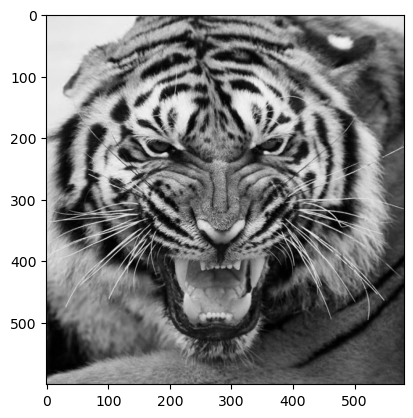

In [40]:
plt.imshow(divided, cmap = "gray")
plt.show()

Hmm, it looks the same. But it is not. It's just plt, that does the magic.

In [41]:
tiger_grayscale.max()

105.315

In [42]:
result.max()

328.86199999999997

In [43]:
tiger_z = (tiger_grayscale - tiger_grayscale.mean()) / tiger_grayscale.std(ddof = 1)

In [44]:
tiger_z.mean(), tiger_z.std(ddof = 1)

(1.5474722397487928e-16, 0.9999999999999997)

In [45]:
tiger_grayscale.mean(), tiger_z.std(ddof = 1) 

(46.011592813218385, 0.9999999999999997)

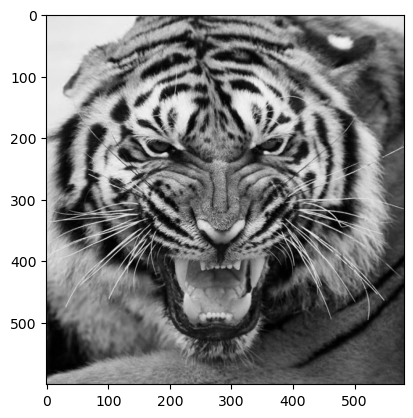

In [46]:
plt.imshow(tiger_z, cmap = "gray")
plt.show()

As we can see, there are not much differences in the images, but the numbers are completely different. In the example above, the numbers become smaller. Which is big advantage! This way is more unlikely to get false results.

In [47]:
# Also, we have a resize function in skimage :D
smaller = resize(tiger_grayscale, (150, 150)) # Change the values if you want to
wider = resize(tiger_grayscale, (150, 300))

In [48]:
smaller

array([[92.70178611, 92.7152055 , 92.87112174, ..., 93.16435376,
        93.26882391, 93.31419653],
       [93.39215605, 93.41246262, 93.28941797, ..., 93.63891716,
        93.32577458, 93.34722484],
       [93.75390197, 93.7755026 , 93.87245632, ..., 93.79075811,
        93.36804448, 93.4364506 ],
       ...,
       [47.33139942, 58.5525331 , 65.80882958, ..., 27.37467784,
        24.23569451, 23.24151513],
       [74.29887688, 73.75469209, 69.5421672 , ..., 26.34748908,
        26.02064103, 25.18764217],
       [69.5390796 , 67.04645933, 65.13766449, ..., 27.5938301 ,
        26.28902995, 26.47510185]])

In [49]:
wider

array([[92.70172286, 92.70183883, 92.70184892, ..., 93.26420393,
        93.34579934, 93.29715911],
       [93.37473989, 93.40809585, 93.4159361 , ..., 93.28264838,
        93.37533713, 93.33453824],
       [93.76124136, 93.74869399, 93.72566444, ..., 93.2492158 ,
        93.49598593, 93.40213283],
       ...,
       [45.04558465, 48.5001421 , 55.2697495 , ..., 23.50624146,
        23.3819082 , 23.03215314],
       [74.15975005, 74.29526481, 74.53949058, ..., 25.65983025,
        25.44019038, 24.8728277 ],
       [70.36134887, 69.00505396, 67.65033176, ..., 26.54182695,
        26.66415686, 26.27314095]])

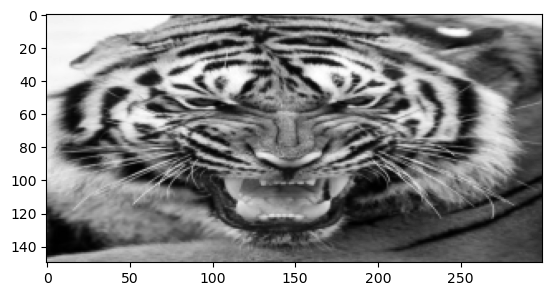

In [50]:
plt.imshow(wider, cmap = "gray")
plt.show()

### Text Processing
Understanding what people write

* Documents, written in plain text
    * News, tweets, blog posts, poems, books, legal documents, etc.
    * May also be auto-generated (i.e., server logs)
* Objective
    * Preprocess the text data so that it's structured
        * Alforithms can analyze a table of numbers, not plain text
            * This is especially true for machine learning algorithms
* Applicaitons
    * Sentiment analysis
    * Grouping texts - similar tipics, similar authors
    * Classification (e.g., spam / fake news prevention)
    * Text summarization, etc.

Texts could also be dna sequences, spanish long names.

For text similarity, we could use [`Levenshtein distance`](https://en.wikipedia.org/wiki/Levenshtein_distance). More about it under the link :D In general, it finds the count of differences in two strings. Other types of distances can be found [here](https://en.wikipedia.org/wiki/Edit_distance).

NLP - Natural Language Processing

In [51]:
# Ok, we have a prepared text (Alice from wonderlance)
# We will use it for the purpose of this exercise
with open ("data/alice.txt", "r") as f:
    text = f.read()

In [52]:
text

"\n\n\nProject Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\nTitle: Alice's Adventures in Wonderland\n\nAuthor: Lewis Carroll\n\nRelease Date: June 25, 2008 [EBook #11]\nLast Updated: October 6, 2016\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\n*** START OF THIS PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN WONDERLAND ***\n\n\n\nProduced by Arthur DiBianca and David Widger\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nALICE’S ADVENTURES\nIN WONDERLAND\n\n\nBy Lewis Carroll\n\n\n\nTHE MILLENNIUM FULCRUM EDITION 3.0\n\n\n\n\n\nContents\nCHAPTER I. \tDown the Rabbit-Hole\nCHAPTER II. \tThe Pool of Tears\nCHAPTER III. \tA Caucus-Race and a Long Tale\nCHAPTER IV. \tThe Rabbit Sends in a Little Bill\nCHAPTER V. \tAdvic

Hm, there is a lot of stuff going on here. Let's try printing it, so we could see it better.

In [53]:
print(text)




Project Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Alice's Adventures in Wonderland

Author: Lewis Carroll

Release Date: June 25, 2008 [EBook #11]
Last Updated: October 6, 2016

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN WONDERLAND ***



Produced by Arthur DiBianca and David Widger

















ALICE’S ADVENTURES
IN WONDERLAND


By Lewis Carroll



THE MILLENNIUM FULCRUM EDITION 3.0





Contents
CHAPTER I. 	Down the Rabbit-Hole
CHAPTER II. 	The Pool of Tears
CHAPTER III. 	A Caucus-Race and a Long Tale
CHAPTER IV. 	The Rabbit Sends in a Little Bill
CHAPTER V. 	Advice from a Caterpillar
CHAPTER VI. 	Pig and Pepper
CHAPTER VII. 	A Mad 

Ok, now that we are good at pirating books online, let's try to do some processing on it.

##### First part - statistics

In [54]:
character_counter = Counter(text)

In [55]:
character_counter

Counter({'\n': 2266,
         'P': 183,
         'r': 6481,
         'o': 9348,
         'j': 222,
         'e': 15243,
         'c': 2843,
         't': 11754,
         ' ': 29580,
         'G': 182,
         'u': 3926,
         'n': 7926,
         'b': 1638,
         'g': 2766,
         "'": 4,
         's': 7054,
         'A': 674,
         'l': 5111,
         'i': 7881,
         'd': 5275,
         'v': 945,
         'W': 231,
         'a': 9172,
         ',': 2566,
         'y': 2489,
         'L': 116,
         'w': 2725,
         'C': 185,
         'T': 487,
         'h': 7669,
         'B': 119,
         'k': 1209,
         'f': 2259,
         'm': 2272,
         '.': 1217,
         'Y': 100,
         'p': 1805,
         '-': 223,
         ':': 255,
         'R': 167,
         'D': 216,
         'J': 13,
         '2': 11,
         '5': 13,
         '0': 21,
         '8': 11,
         '[': 3,
         'E': 198,
         '#': 1,
         '1': 66,
         ']': 3,
         'U': 64

White space is used the most. What a suprise xd

In [56]:
character_counter.most_common(20)

[(' ', 29580),
 ('e', 15243),
 ('t', 11754),
 ('o', 9348),
 ('a', 9172),
 ('n', 7926),
 ('i', 7881),
 ('h', 7669),
 ('s', 7054),
 ('r', 6481),
 ('d', 5275),
 ('l', 5111),
 ('u', 3926),
 ('c', 2843),
 ('g', 2766),
 ('w', 2725),
 (',', 2566),
 ('y', 2489),
 ('m', 2272),
 ('\n', 2266)]

In [57]:
characters = character_counter.most_common(20)

In [58]:
[ch[1] for ch in characters]

[29580,
 15243,
 11754,
 9348,
 9172,
 7926,
 7881,
 7669,
 7054,
 6481,
 5275,
 5111,
 3926,
 2843,
 2766,
 2725,
 2566,
 2489,
 2272,
 2266]

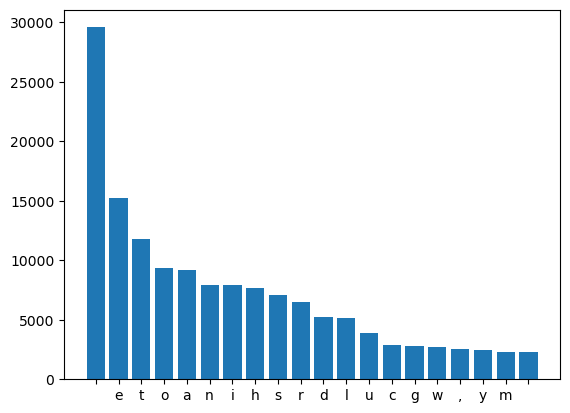

In [59]:
plt.bar([ch[0] for ch in characters], [ch[1] for ch in characters])
plt.show()

The result is not that suprising. [etaion shrdlu](https://en.wikipedia.org/wiki/Etaoin_shrdlu)

Now let's try getting all words. We will use RegEx.

In [60]:
re.split("\W+", text)

['',
 'Project',
 'Gutenberg',
 's',
 'Alice',
 's',
 'Adventures',
 'in',
 'Wonderland',
 'by',
 'Lewis',
 'Carroll',
 'This',
 'eBook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere',
 'at',
 'no',
 'cost',
 'and',
 'with',
 'almost',
 'no',
 'restrictions',
 'whatsoever',
 'You',
 'may',
 'copy',
 'it',
 'give',
 'it',
 'away',
 'or',
 're',
 'use',
 'it',
 'under',
 'the',
 'terms',
 'of',
 'the',
 'Project',
 'Gutenberg',
 'License',
 'included',
 'with',
 'this',
 'eBook',
 'or',
 'online',
 'at',
 'www',
 'gutenberg',
 'org',
 'Title',
 'Alice',
 's',
 'Adventures',
 'in',
 'Wonderland',
 'Author',
 'Lewis',
 'Carroll',
 'Release',
 'Date',
 'June',
 '25',
 '2008',
 'EBook',
 '11',
 'Last',
 'Updated',
 'October',
 '6',
 '2016',
 'Language',
 'English',
 'Character',
 'set',
 'encoding',
 'UTF',
 '8',
 'START',
 'OF',
 'THIS',
 'PROJECT',
 'GUTENBERG',
 'EBOOK',
 'ALICE',
 'S',
 'ADVENTURES',
 'IN',
 'WONDERLAND',
 'Produced',
 'by',
 'Arthur',
 'DiBianca',
 'and',

In [61]:
words = re.split("\W+", text)

In [62]:
words_counter = Counter(words)

In [63]:
# Let's see the most commonly used words
words_counter.most_common(20)

[('the', 1693),
 ('and', 875),
 ('to', 802),
 ('a', 677),
 ('of', 609),
 ('I', 546),
 ('it', 543),
 ('she', 513),
 ('said', 458),
 ('in', 416),
 ('you', 408),
 ('Alice', 401),
 ('was', 357),
 ('that', 299),
 ('as', 256),
 ('her', 245),
 ('with', 223),
 ('at', 218),
 ('t', 217),
 ('s', 214)]

So the most common word is `said`? Well, this could help us distinguish the genre of the book, no?

### Preparing Text Data
* Before we start working with the text, we have to "normalize" and clean up the messy data
    * Remove all non-letter characters
        * Numbers, punctuation, whitespaces, etc.
        * If needed, apply additional rules, e.g., if we're looking at tweets, **@mention** means a username and we may want to get rid of it
    * Transform all characters to lowercase
    * Remove "stopwords"
        * Words that are too frequent in all documents and don't contain much information, such as "the", "a", "is", etc.
    * Perform stemming
        * Extract the stems of all words, e.g. "connected", "connection", "connecting" should all point to "connect"

In [64]:
# For example, there may be the same words with different casing eg: We and we
words = [w.lower() for w in words]

In [65]:
# See, the counter changed
words

['',
 'project',
 'gutenberg',
 's',
 'alice',
 's',
 'adventures',
 'in',
 'wonderland',
 'by',
 'lewis',
 'carroll',
 'this',
 'ebook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere',
 'at',
 'no',
 'cost',
 'and',
 'with',
 'almost',
 'no',
 'restrictions',
 'whatsoever',
 'you',
 'may',
 'copy',
 'it',
 'give',
 'it',
 'away',
 'or',
 're',
 'use',
 'it',
 'under',
 'the',
 'terms',
 'of',
 'the',
 'project',
 'gutenberg',
 'license',
 'included',
 'with',
 'this',
 'ebook',
 'or',
 'online',
 'at',
 'www',
 'gutenberg',
 'org',
 'title',
 'alice',
 's',
 'adventures',
 'in',
 'wonderland',
 'author',
 'lewis',
 'carroll',
 'release',
 'date',
 'june',
 '25',
 '2008',
 'ebook',
 '11',
 'last',
 'updated',
 'october',
 '6',
 '2016',
 'language',
 'english',
 'character',
 'set',
 'encoding',
 'utf',
 '8',
 'start',
 'of',
 'this',
 'project',
 'gutenberg',
 'ebook',
 'alice',
 's',
 'adventures',
 'in',
 'wonderland',
 'produced',
 'by',
 'arthur',
 'dibianca',
 'and',

In [66]:
# NLTK has stopwords avaliable. Check the imports
stopwords

<WordListCorpusReader in '.../corpora/stopwords' (not loaded yet)>

In [67]:
# Not working on my pc, should try later, but believe me - it works
# stop = set(stopwords.words("english"))

In [68]:
# words = [w for w in words if not in stop]

For stemming we have the `PorterStemmer` in the NLTK module :D

In [71]:
PorterStemmer()

<PorterStemmer>

In [72]:
stemmer = PorterStemmer()
words = ["caresses", "flies", "dies", "seizing", "itemization",
"sensational", "traditional", "reference", "plotted"]
print([stemmer.stem(word) for word in words])

['caress', 'fli', 'die', 'seiz', 'item', 'sensat', 'tradit', 'refer', 'plot']


As we can see, the stemmer got the stems all by itself. But it works mainly in english :) So make sure to look at your language. Other similar process is lemartization.

Here we are using the `fetch 20 news groups` dataset from sklearn.

In [74]:
# It's big xd
fetch_20newsgroups()

{'data': ["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
  "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washingto

In [75]:
fetch_20newsgroups()["data"]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [76]:
fetch_20newsgroups()["data"][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [77]:
fetch_20newsgroups()["target"]

array([7, 4, 4, ..., 3, 1, 8])

In [79]:
corpus = fetch_20newsgroups()["data"]

In our case vectorization means feature extraction.

In [81]:
count_vectorizer = CountVectorizer()

In [82]:
count_vectorizer.fit(corpus)

CountVectorizer()

In [83]:
count_vectorizer.vocabulary_

{'from': 56979,
 'lerxst': 75358,
 'wam': 123162,
 'umd': 118280,
 'edu': 50527,
 'where': 124031,
 'my': 85354,
 'thing': 114688,
 'subject': 111322,
 'what': 123984,
 'car': 37780,
 'is': 68532,
 'this': 114731,
 'nntp': 87620,
 'posting': 95162,
 'host': 64095,
 'rac3': 98949,
 'organization': 90379,
 'university': 118983,
 'of': 89362,
 'maryland': 79666,
 'college': 40998,
 'park': 92081,
 'lines': 76032,
 '15': 4605,
 'was': 123292,
 'wondering': 124931,
 'if': 65798,
 'anyone': 28615,
 'out': 90774,
 'there': 114579,
 'could': 42876,
 'enlighten': 51793,
 'me': 80638,
 'on': 89860,
 'saw': 104813,
 'the': 114455,
 'other': 90686,
 'day': 45295,
 'it': 68766,
 'door': 48618,
 'sports': 109581,
 'looked': 76718,
 'to': 115475,
 'be': 32311,
 'late': 74693,
 '60s': 16574,
 'early': 50111,
 '70s': 18299,
 'called': 37433,
 'bricklin': 34995,
 'doors': 48620,
 'were': 123796,
 'really': 99822,
 'small': 108252,
 'in': 66608,
 'addition': 26073,
 'front': 56989,
 'bumper': 35612,
 'se

In [84]:
count_vectorizer.transform(corpus)

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

From what we could see - we don't want words, which are too common, or too rare in our text. For example stop words, or typos.

### TF - IDF
* **T**erm **f**requency - **i**nverse **d**ocument **f**requency
    * A common method to preprocess the text 
    <img src="images/tfidf.png" />
    * High score: rare specific words
        * Hypothesis: these may be better related to the topic
        * Note: This may also include misspelled words and / or names
    * Low score: words, that occur in nearly all documents

In [86]:
# We use TfidfVectorizer for the TF-IDF 
tfidf = TfidfVectorizer()

In [88]:
tfidf_matrix = tfidf.fit_transform(corpus)

In [89]:
tfidf_matrix

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [91]:
feature_names = tfidf.get_feature_names_out()

In [92]:
feature_names

array(['00', '000', '0000', ..., 'íålittin', 'ñaustin', 'ýé'],
      dtype=object)

In [94]:
doc = 0 # Change the index to view another document
feature_index = tfidf_matrix[doc, :].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

neighborhood 0.13157118714240987
your 0.04278499079283093
by 0.03770448563619875
brought 0.09353930598317124
il 0.09785515708314481
thanks 0.05511105154696676
mail 0.05989856888061599
please 0.055457031390147224
looking 0.06908779999621749
funky 0.1558717009157704
have 0.02921527992427867
you 0.05922294083277842
info 0.07313443922740179
whatever 0.08207027465330353
or 0.031889368795417566
history 0.08342748387969037
made 0.0633940918806495
production 0.10826904490745741
years 0.060622095889758885
specs 0.10844724822064673
engine 0.09714744057976722
name 0.07000411445838192
model 0.08844382496462173
tellme 0.17691750674853082
can 0.03431760442478462
know 0.042808253355525495
all 0.037098931990947055
body 0.08716420445779295
rest 0.08171219473190486
separate 0.09869734624201922
bumper 0.1328075333935896
front 0.08646962500270383
addition 0.09534869974107982
in 0.02245166215306426
small 0.07526015712540636
really 0.0566656180826706
were 0.049437556160455476
doors 0.11603642565244157
brick

TF-IDF gives a grade, based on the frequency :)

Check garden path sentences!

Embedding - Converting something to less dimensions


Date: 06.07.20203